In [1]:
#Evaluatin a RBF NN regressor with a simulated escenario (reality)


#Part of this test elaborated by: https://github.com/robertorolo/neural_networks_grades_estimation/tree/master

import geostatspy.GSLIB as GSLIB                          # Utilidades GSLIB y funciones envueltas
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import os                                                 # Para configurar el directorio de trabajo
import numpy as np                                        # Biblioteca de funciones matemáticas
import pandas as pd                                       # Biblioteca para manipulación de marcos de datos
import matplotlib.pyplot as plt                           # Biblioteca para salida gráfica
import scipy.stats                                        # Biblioteca de resumenes estadísticos y matemáticos
import random as rand

os.chdir("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER") # ruta de ejecutables de GSLIB

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import pygeostat as gs
from RBFN import *                                       #Este código esta en la carpeta 
%matplotlib inline

## Data creation and sample extraction:

In [2]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size=10                             # grid number of cells and cell size

xmin = 0; ymin =0;                                          # grid origin

xmax = 1000; ymax = 1000    # calculate the extent of model
seed = 172763650

vmin = 0; vmax = 1; cmap = plt.cm.jet                     # color min and max and using the plasma color map

In [3]:
# Make a truth model / unconditional simulation
va_mean = 2; va_stdev = 0.55; va_cmin = 0; va_cmax = 4
var = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90,hmaj1=500,hmin1=500)
V = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed,var,"u")
V = GSLIB.affine(V,va_mean,va_stdev)
df_zko = pd.DataFrame(V)
df11 = df_zko.stack().reset_index().rename(columns={"level_0": "Norte[Y]", "level_1": "Este[X]", 0:"V"})
x = df11["Norte[Y]"].iloc[::-1].reset_index()
df11["Norte[Y]"] = x["Norte[Y]"]
##############################################################################################################
grid_x = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.
#En este caso la matriz es de 100 x 100 celdas.
gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 
yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)
x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg
d = {'X': x_g, 'Y': y_g} #Columnas con coordenadas X e Y.
df = pd.DataFrame(data=d) #Creación del dataframe 
h = df["Y"].iloc[::-1].reset_index()
df["Y"] = h["Y"]
df["V"] = df11["V"] #Traspaso de la columna VA al nuevo DataFrame.
df.to_csv("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER/data/sim_data.csv")
df.head()

,X,Y,V
0,0.0,990.0,0.754091
1,10.0,990.0,0.598761
2,20.0,990.0,0.442244
3,30.0,990.0,0.554724
4,40.0,990.0,0.758951


In [4]:
sim = gs.DataFile('data/sim_data.csv')
sim['Z'] = np.zeros(len(sim))
sim.z = 'Z'

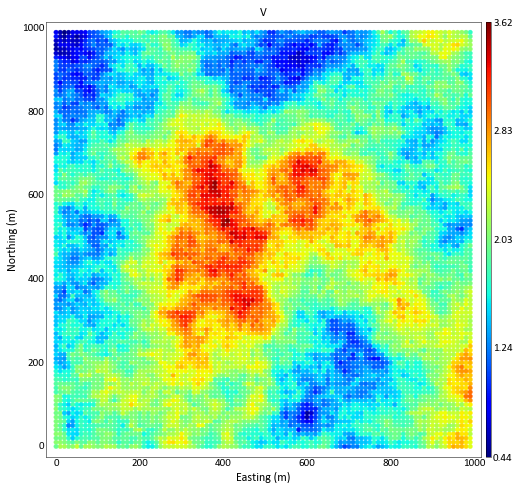

In [5]:
gs.location_plot(sim, var='V', cmap="jet")

In [84]:
# Make a datset by sampling from the truth model, and display the histogram and location map
mx = 20; my =20

sample_data1 = GSLIB.regular_sample(V,xmin,xmax,ymin,ymax,cell_size,mx,my,nx,ny,"V")

nsamp_random = 400

sample_data2 = GSLIB.random_sample(V,xmin,xmax,ymin,ymax,cell_size,nsamp_random,'V')

sample_data = pd.concat([sample_data1,sample_data2],ignore_index = True)

In [85]:
print((sample_data["V"].count() * 100/df11["V"].count()), "% es el tamaño de la muestra")

4.16 % es el tamaño de la muestra


In [86]:
sample_data.to_csv("C:/Users/nubem/Documents/NUBEMINERA_2020/GSLIB_FOLDER/data/sample_data.csv")

In [87]:
sample = gs.DataFile('data/sample_data.csv')
sample.drop(columns=['Unnamed: 0'])
sample['Z'] = np.zeros(len(sample))
sample.z = 'Z'
data_coords = sample[['X','Y','Z']] #Variables de entrada que alimentaran la RNA
sample.head()

,X,Y,V,Z
0,200.0,800.0,1.364708,0.0
1,200.0,600.0,2.115032,0.0
2,200.0,400.0,2.226239,0.0
3,200.0,200.0,2.070056,0.0
4,400.0,800.0,1.916981,0.0


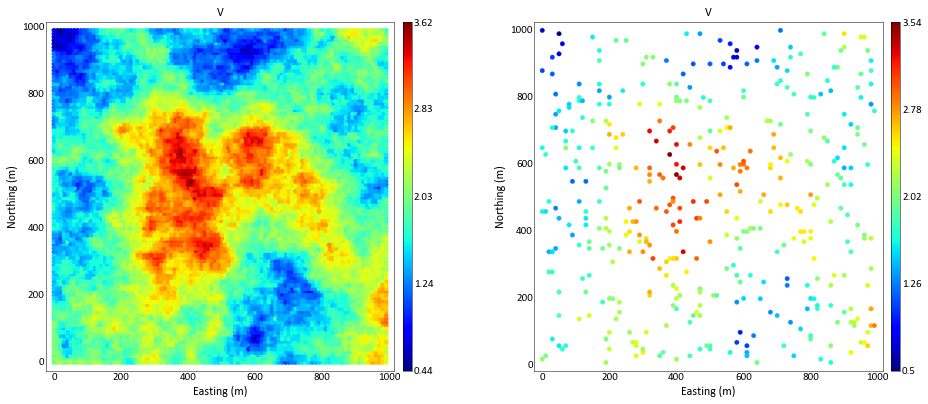

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
plt.subplots_adjust(wspace=0.4)
gs.location_plot(sim, var='V', cmap="jet",ax=ax1)
gs.location_plot(sample, var='V', cmap="jet",ax=ax2)

# Settinng parameters and creating RBFN object

In [89]:
n_clus = 120

In [90]:
centers = KMeans(n_clusters=n_clus).fit(data_coords).cluster_centers_

In [91]:
rbf_n = RBFN(cluster_centers=centers,sigma=None, function='gaussian')

Sigma value set
Random weights set


In [92]:
rbf_n.random_bias()

Random bias: 0.12571190854374448


**Define Grid Set:**

In [93]:
grid = sample.infergriddef(blksize=(10,10,0))
grid = grid.convert_to_2d(orient='xy')
grid_coords = grid.get_coordinates()
grid_coords = np.array([grid_coords[0], grid_coords[1], grid_coords[2]]).T

# Predicting with random weights

In [94]:
predict = rbf_n.predict(grid_coords)

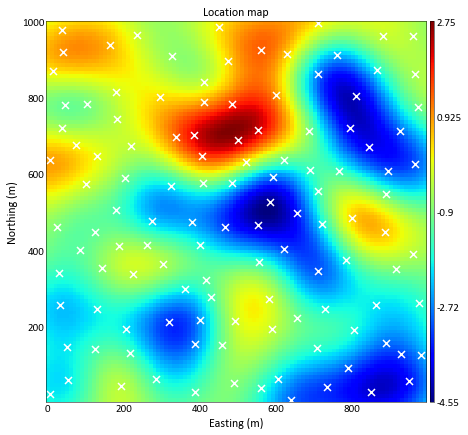

In [95]:
f, a = plt.subplots(1, 1, figsize=(7,7))
_ = gs.slice_plot(predict, griddef=grid, ax=a, title='Location map',cmap='jet')
_ = a.scatter(centers.T[0], centers.T[1], marker='x', color='white')

# Training

In [96]:
X_train, X_test, y_train, y_test = train_test_split(data_coords, sample['V'], test_size=0.2)

Epoch: 0 
 loss: 2229.125206406434
Epoch: 500 
 loss: 11.12592857647714
Epoch: 1000 
 loss: 7.0209503137872025
Epoch: 1500 
 loss: 5.890505049760338


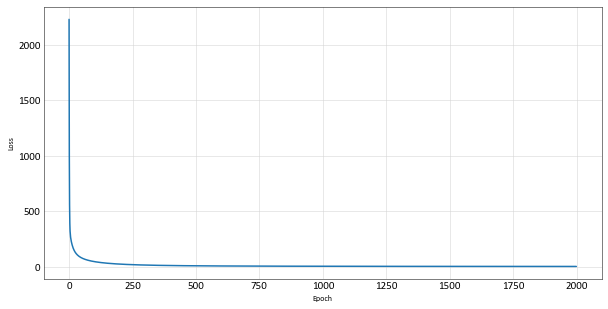

In [97]:
rbf_n.train(2000, X_train, y_train, learning_rate_w=-0.001)

In [98]:
predict_after_train = rbf_n.predict(grid_coords)

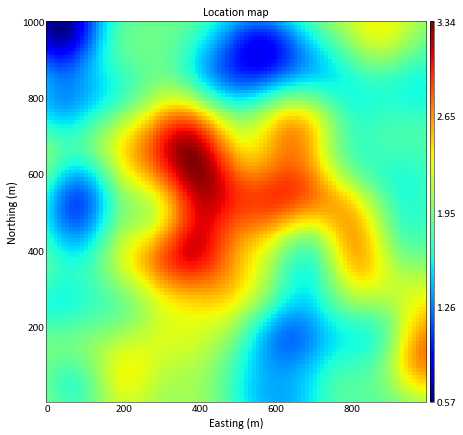

In [99]:
f, a = plt.subplots(1, 1, figsize=(7,7))
_ = gs.slice_plot(predict_after_train, griddef=grid, ax=a, title='Location map',cmap="jet")

#_ = a.scatter(centers.T[0], centers.T[1], marker='x', color='white')

# Validating

In [100]:
predict_test = rbf_n.predict(X_test)

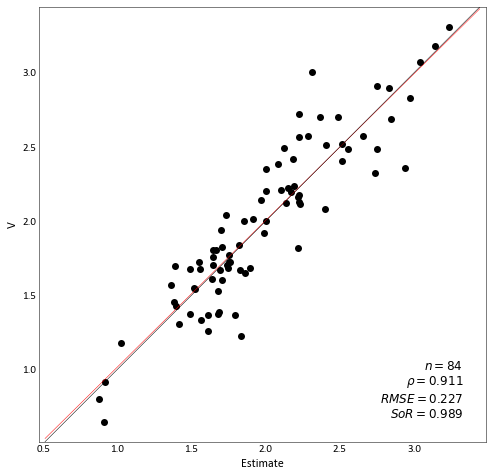

In [101]:
_  = gs.validation_plot(predict_test, y_test,stat_blk='minimal')

**Comparativa Estimación vs Realidad:**

In [102]:
sim.head()

,X,Y,V,Z
0,0.0,990.0,0.754091,0.0
1,10.0,990.0,0.598761,0.0
2,20.0,990.0,0.442244,0.0
3,30.0,990.0,0.554724,0.0
4,40.0,990.0,0.758951,0.0


In [103]:
data = pd.DataFrame()
data["X"] = sim["X"]
data["Y"] = sim["Y"]
data["Z"] = sim["Z"]
data["V_real"] = sim["V"]
data.head()

,X,Y,Z,V_real
0,0.0,990.0,0.0,0.754091
1,10.0,990.0,0.0,0.598761
2,20.0,990.0,0.0,0.442244
3,30.0,990.0,0.0,0.554724
4,40.0,990.0,0.0,0.758951


In [104]:
data2 = data.sort_values(['X', 'Y'],ascending=False).reset_index()
data2.drop(columns=["index"], inplace=True)
data2.head()

,X,Y,Z,V_real
0,990.0,990.0,0.0,1.739642
1,990.0,980.0,0.0,1.923540
2,990.0,970.0,0.0,2.122326
3,990.0,960.0,0.0,2.161806
4,990.0,950.0,0.0,2.102925


In [105]:
est_ = pd.DataFrame(predict_after_train, columns=["V_est"]).iloc[::-1].reset_index()
est_new = est_["V_est"]
data2["V_est"] = est_new
data2.head()

,X,Y,Z,V_real,V_est
0,990.0,990.0,0.0,1.739642,2.025107
1,990.0,980.0,0.0,1.923540,2.053099
2,990.0,970.0,0.0,2.122326,2.084327
3,990.0,960.0,0.0,2.161806,2.117996
4,990.0,950.0,0.0,2.102925,2.153099


In [106]:
data3 = pd.DataFrame()
data3["X"] = data2["Y"]
data3["Y"] = data2["X"]
data3["Z"] = data2["Z"]
data3["V_est"] = data2["V_est"]
data3.head()

,X,Y,Z,V_est
0,990.0,990.0,0.0,2.025107
1,980.0,990.0,0.0,2.053099
2,970.0,990.0,0.0,2.084327
3,960.0,990.0,0.0,2.117996
4,950.0,990.0,0.0,2.153099


In [107]:
merged_df = pd.merge(data2, data3, on=['X', 'Y'])
merged_df.head()

,X,Y,Z_x,V_real,V_est_x,Z_y,V_est_y
0,990.0,990.0,0.0,1.739642,2.025107,0.0,2.025107
1,990.0,980.0,0.0,1.923540,2.053099,0.0,2.009693
2,990.0,970.0,0.0,2.122326,2.084327,0.0,1.990270
3,990.0,960.0,0.0,2.161806,2.117996,0.0,1.966950
4,990.0,950.0,0.0,2.102925,2.153099,0.0,1.940033


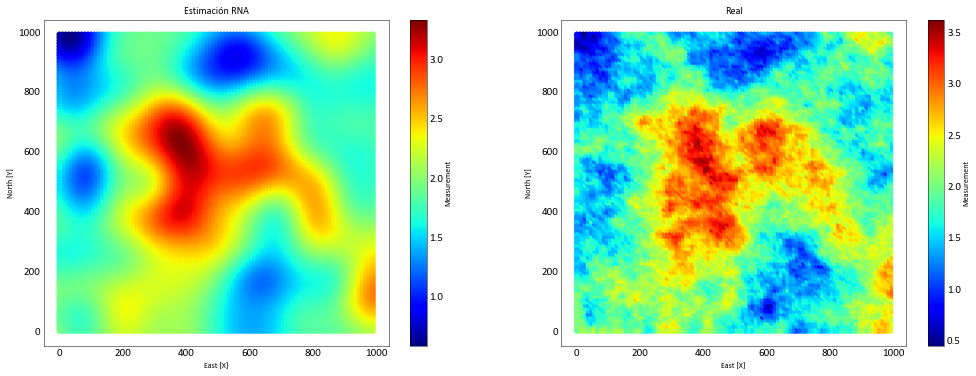

In [108]:
marker_size=30
fig = plt.figure(figsize=(17,6))
plt.subplot(121)
plt.scatter(merged_df["X"], merged_df["Y"], marker_size, merged_df["V_est_y"], cmap = plt.cm.jet)
plt.title("Estimación RNA")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.subplot(122)
plt.scatter(merged_df["X"], merged_df["Y"], marker_size, merged_df["V_real"], cmap = plt.cm.jet)
plt.title("Real")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.show()

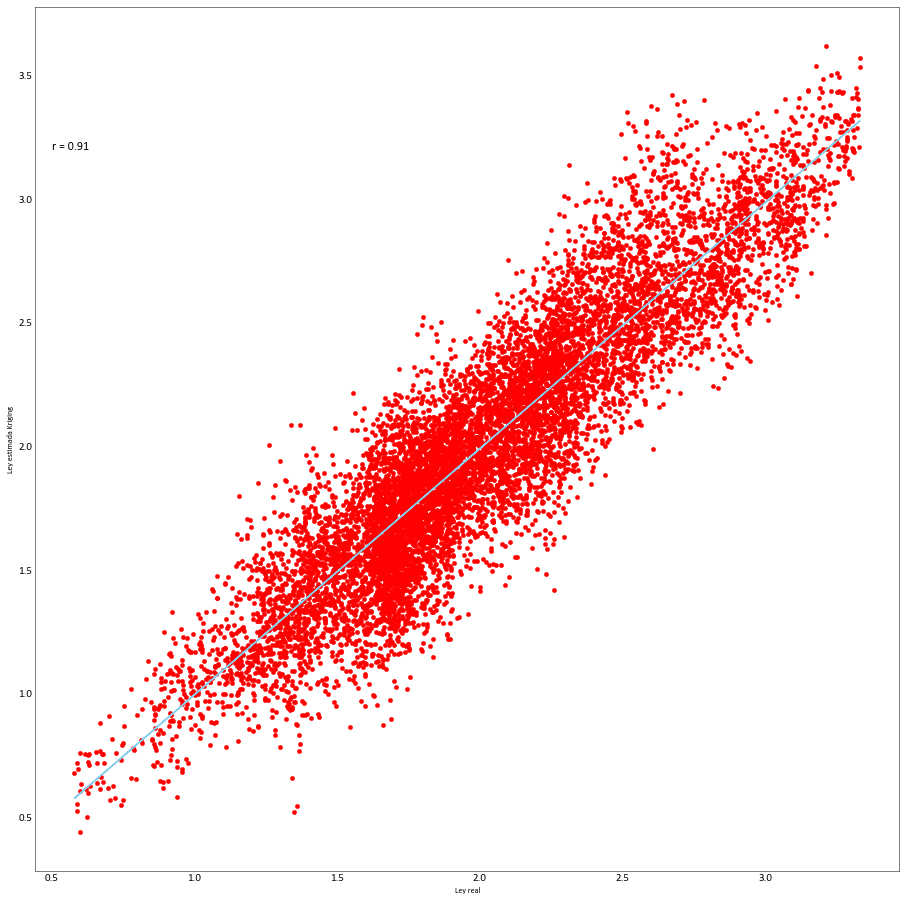

In [109]:
x = merged_df["V_est_y"]
y = merged_df["V_real"] 
#Calculando los coeficientes del ajuste de regresión:
a, b = np.polyfit(x, y, 1) # 1 es el grado del polinomio
r = np.corrcoef(x, y) # r = coeficiente de correlación
#print("R:", r, "a:", a, "b:", b) # b: pendiente de la recta, a: ordenada en la vertical (Y = bX + a)
plt.subplot(111)
plt.scatter(x,y, color="r", s=20)
plt.xlabel("Ley real")
plt.ylabel("Ley estimada Kriging")
plt.plot(x, a * x + b, color="skyblue")
plt.text(0.5,3.2, 'r = {0:2.2f}'.format(r[0,1]))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5)
plt.show()